# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '13'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc_ice.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2483775)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 00:45:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    ssi  = xr.open_dataset(fname).ssi.values
    q_i  = xr.open_dataset(fname).q_ice.values
    n_i  = xr.open_dataset(fname).n_ice.values
    # process rates
    depo = xr.open_dataset(fname).depo_ice_mass.values   
    # normalize with ssi 
    depo = np.where(ssi>1e-4,depo/ssi,np.nan)
    # values of ssi above 1e-2 are mixed-phase and at water saturation
    depo = np.where(ssi<1e-2,depo,np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    q_i = np.log(q_i, where=q_i>q_min, out=np.nan*q_i)
    n_i = np.log(n_i, where=n_i>n_min, out=np.nan*n_i)
    depo = np.log(depo, where=depo>p_min, out=np.nan*depo)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_i, n_i, temp, ssi, rho, depo ]))
    dataset = dataset.T
    dataset.columns = [ 'q_i', 'n_i', 'temp', 'ssi', 'rho', 'depo' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_i           n_i          temp           ssi           rho  \
count  1.809696e+06  1.809696e+06  1.809696e+06  1.809696e+06  1.809696e+06   
mean  -9.420649e+00  1.344154e+01  2.421186e+02  4.143908e-03  6.932771e-01   
std    3.259941e+00  3.821718e+00  1.148768e+01  2.145147e-03  1.437253e-01   
min   -2.302555e+01 -3.465736e+00  2.066500e+02  2.000000e-04  4.270000e-01   
25%   -9.659507e+00  1.194575e+01  2.340800e+02  2.700000e-03  5.880000e-01   
50%   -8.562609e+00  1.405539e+01  2.417400e+02  3.300000e-03  6.770000e-01   
75%   -7.580061e+00  1.610534e+01  2.493100e+02  5.200000e-03  7.710000e-01   
max   -4.315790e+00  2.051684e+01  2.731500e+02  9.900000e-03  1.288000e+00   

               depo  
count  1.809696e+06  
mean  -1.287741e+01  
std    3.035055e+00  
min   -3.075024e+01  
25%   -1.381970e+01  
50%   -1.245308e+01  
75%   -1.093181e+01  
max   -4.156553e+00

### Separate in training, validation and test data

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_i        n_i        temp     ssi    rho       depo
1 -9.098263  11.622676  243.710007  0.0098  0.699 -13.520217
2 -9.102742  11.618186  243.779999  0.0098  0.700 -13.518085
4 -9.112307  11.609235  243.929993  0.0098  0.702 -13.514643
6 -9.117306  11.601485  244.070007  0.0098  0.704 -13.507861
7 -9.120774  11.597083  244.139999  0.0098  0.705 -13.505104

In [11]:
dataset_train.describe()

q_i           n_i          temp           ssi           rho  \
count  1.267364e+06  1.267364e+06  1.267364e+06  1.267364e+06  1.267364e+06   
mean  -9.421195e+00  1.344127e+01  2.421187e+02  4.142902e-03  6.932707e-01   
std    3.259679e+00  3.822259e+00  1.148862e+01  2.143839e-03  1.437455e-01   
min   -2.302545e+01 -3.465736e+00  2.066500e+02  2.000000e-04  4.270000e-01   
25%   -9.659934e+00  1.194614e+01  2.340900e+02  2.700000e-03  5.890000e-01   
50%   -8.562766e+00  1.405610e+01  2.417400e+02  3.300000e-03  6.770000e-01   
75%   -7.581610e+00  1.610438e+01  2.493200e+02  5.200000e-03  7.710000e-01   
max   -4.315790e+00  2.051684e+01  2.731500e+02  9.900000e-03  1.288000e+00   

               depo  
count  1.267364e+06  
mean  -1.287786e+01  
std    3.035256e+00  
min   -3.075024e+01  
25%   -1.382054e+01  
50%   -1.245326e+01  
75%   -1.093302e+01  
max   -4.156553e+00

In [12]:
dataset_test.describe()

q_i            n_i           temp            ssi  \
count  270634.000000  270634.000000  270634.000000  270634.000000   
mean       -9.425249      13.436594     242.130020       0.004146   
std         3.269694       3.832476      11.510557       0.002148   
min       -23.025551      -3.219651     206.860001       0.000200   
25%        -9.667862      11.934608     234.070007       0.002700   
50%        -8.563080      14.054410     241.759995       0.003300   
75%        -7.573798      16.111217     249.339996       0.005200   
max        -4.325495      20.516451     273.149994       0.009900   

                 rho           depo  
count  270634.000000  270634.000000  
mean        0.693434     -12.880790  
std         0.144011       3.041373  
min         0.428000     -28.869076  
25%         0.588000     -13.818391  
50%         0.677000     -12.451068  
75%         0.771000     -10.931197  
max         1.281000      -4.428456

In [13]:
dataset_val.describe()

q_i            n_i           temp            ssi  \
count  271698.000000  271698.000000  271698.000000  271698.000000   
mean       -9.413504      13.447719     242.106247       0.004146   
std         3.251423       3.808447      11.460495       0.002149   
min       -23.025551      -3.348045     206.720001       0.000200   
25%        -9.648810      11.954787     234.080002       0.002700   
50%        -8.561354      14.052597     241.759995       0.003300   
75%        -7.578535      16.104585     249.259995       0.005200   
max        -4.363165      20.516451     273.149994       0.009900   

                 rho           depo  
count  271698.000000  271698.000000  
mean        0.693151     -12.871964  
std         0.143347       3.027813  
min         0.427000     -26.817106  
25%         0.589000     -13.817028  
50%         0.678000     -12.453977  
75%         0.770000     -10.925889  
max         1.288000      -4.702160

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_i'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_i           n_i          temp           ssi           rho  \
count  1.234870e+06  1.234870e+06  1.234870e+06  1.234870e+06  1.234870e+06   
mean  -9.120358e+00  1.374614e+01  2.415452e+02  4.147865e-03  6.854934e-01   
std    2.695270e+00  3.352947e+00  1.102616e+01  2.141057e-03  1.361440e-01   
min   -1.999998e+01 -8.817444e-01  2.066500e+02  1.400000e-03  4.270000e-01   
25%   -9.503410e+00  1.213624e+01  2.338300e+02  2.700000e-03  5.850000e-01   
50%   -8.517143e+00  1.416112e+01  2.413900e+02  3.300000e-03  6.730000e-01   
75%   -7.551750e+00  1.615337e+01  2.486300e+02  5.200000e-03  7.610000e-01   
max   -4.315790e+00  2.051684e+01  2.730000e+02  9.900000e-03  1.275000e+00   

               depo  
count  1.234870e+06  
mean  -1.261455e+01  
std    2.576520e+00  
min   -2.384988e+01  
25%   -1.369794e+01  
50%   -1.237858e+01  
75%   -1.089232e+01  
max   -4.156553e+00

In [17]:
dataset_test.describe()

q_i            n_i           temp            ssi  \
count  263676.000000  263676.000000  263676.000000  263676.000000   
mean       -9.122869      13.742980     241.557343       0.004151   
std         2.703738       3.361465      11.053679       0.002144   
min       -19.999638      -0.470004     206.860001       0.001400   
25%        -9.512815      12.127340     233.820007       0.002700   
50%        -8.517593      14.162852     241.410004       0.003300   
75%        -7.542666      16.161442     248.649994       0.005200   
max        -4.325495      20.516451     273.000000       0.009900   

                 rho           depo  
count  263676.000000  263676.000000  
mean        0.685671     -12.616145  
std         0.136498       2.580907  
min         0.428000     -23.867407  
25%         0.585000     -13.697453  
50%         0.673000     -12.377769  
75%         0.762000     -10.890463  
max         1.281000      -4.428456

### Pairplot

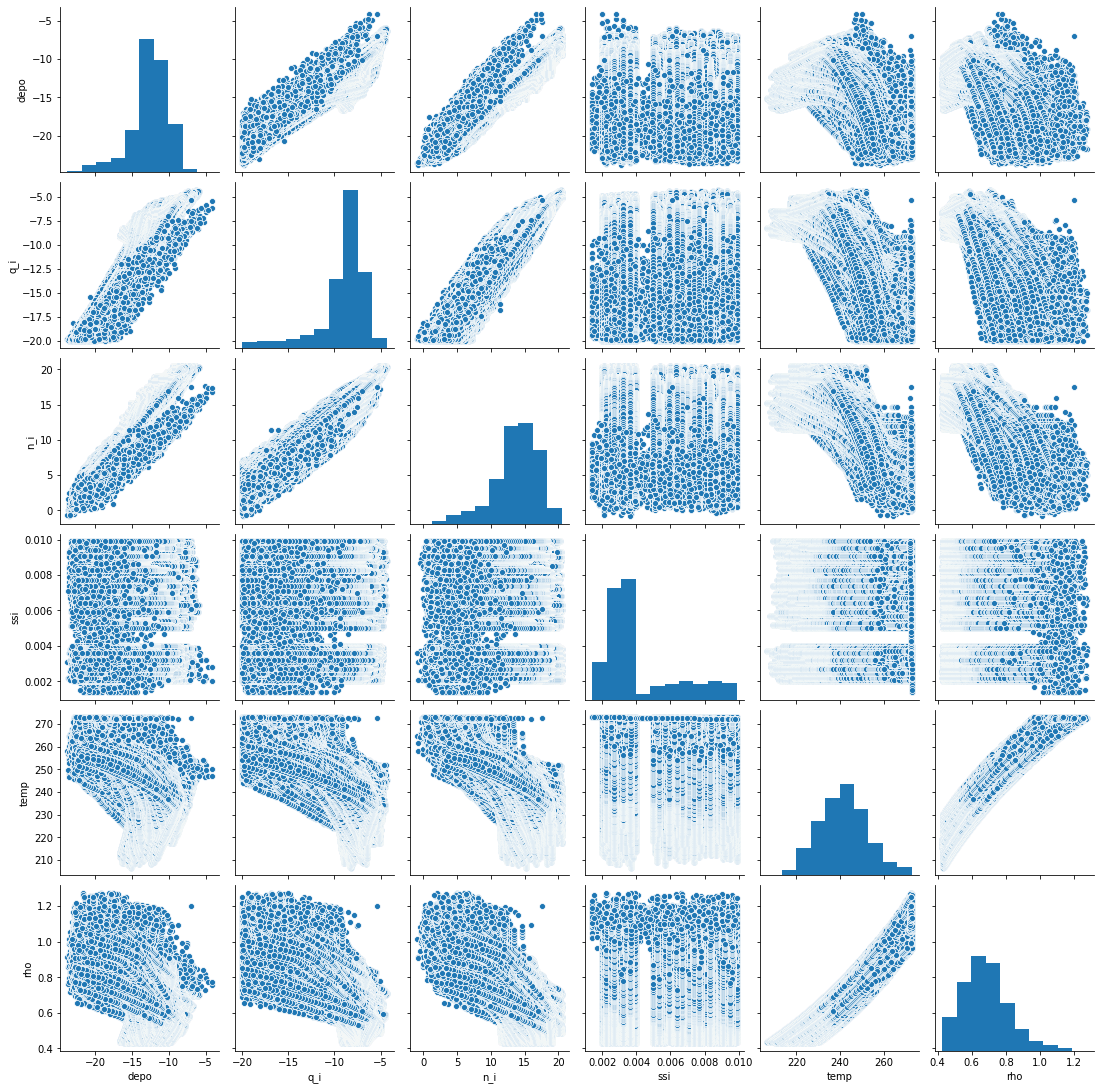

In [18]:
sns.pairplot(dataset_train[["depo","q_i","n_i","ssi","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
train_dataset2 = train_dataset2.drop(['ssi'], axis=1)
train_dataset3 = train_dataset3.drop(['ssi'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
test_dataset2 = test_dataset2.drop(['ssi'], axis=1)
test_dataset3 = test_dataset3.drop(['ssi'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
val_dataset2 = val_dataset2.drop(['ssi'], axis=1)
val_dataset3 = val_dataset3.drop(['ssi'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("depo")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min       25%        50%  \
q_i  1234870.0  -9.120358  2.695270 -19.999977  -9.50341  -8.517143   
n_i  1234870.0  13.746137  3.352947  -0.881744  12.13624  14.161119   

           75%        max  
q_i  -7.551750  -4.315790  
n_i  16.153366  20.516844

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("depo")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean        std         min         25%         50%  \
q_i   1234870.0   -9.120358   2.695270  -19.999977   -9.503410   -8.517143   
n_i   1234870.0   13.746137   3.352947   -0.881744   12.136240   14.161119   
temp  1234870.0  241.545151  11.026160  206.649994  233.830002  241.389999   
rho   1234870.0    0.685493   0.136144    0.427000    0.585000    0.673000   

             75%         max  
q_i    -7.551750   -4.315790  
n_i    16.153366   20.516844  
temp  248.630005  273.000000  
rho     0.761000    1.275000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("depo")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
q_i   1234870.0   -9.120358   2.695270  -19.999977   -9.503410   -8.517143   
n_i   1234870.0   13.746137   3.352947   -0.881744   12.136240   14.161119   
temp  1234870.0  241.545151  11.026160  206.649994  233.830002  241.389999   
rho   1234870.0    0.685493   0.136144    0.427000    0.585000    0.673000   

             75%         max  
q_i    -7.551750   -4.315790  
n_i    16.153366   20.516844  
temp  248.630005  273.000000  
rho     0.761000    1.275000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['depo']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

depo
count  1.234870e+06
mean  -1.261455e+01
std    2.576520e+00
min   -2.384988e+01
25%   -1.369794e+01
50%   -1.237858e+01
75%   -1.089232e+01
max   -4.156553e+00

In [32]:
train_dataset1.describe()

q_i           n_i
count  1.234870e+06  1.234870e+06
mean  -9.120358e+00  1.374614e+01
std    2.695270e+00  3.352947e+00
min   -1.999998e+01 -8.817444e-01
25%   -9.503410e+00  1.213624e+01
50%   -8.517143e+00  1.416112e+01
75%   -7.551750e+00  1.615337e+01
max   -4.315790e+00  2.051684e+01

In [33]:
train_dataset2.describe()

q_i           n_i          temp           rho
count  1.234870e+06  1.234870e+06  1.234870e+06  1.234870e+06
mean  -9.120358e+00  1.374614e+01  2.415452e+02  6.854934e-01
std    2.695270e+00  3.352947e+00  1.102616e+01  1.361440e-01
min   -1.999998e+01 -8.817444e-01  2.066500e+02  4.270000e-01
25%   -9.503410e+00  1.213624e+01  2.338300e+02  5.850000e-01
50%   -8.517143e+00  1.416112e+01  2.413900e+02  6.730000e-01
75%   -7.551750e+00  1.615337e+01  2.486300e+02  7.610000e-01
max   -4.315790e+00  2.051684e+01  2.730000e+02  1.275000e+00

In [34]:
train_dataset3.describe()

q_i           n_i          temp           rho
count  1.234870e+06  1.234870e+06  1.234870e+06  1.234870e+06
mean  -9.120358e+00  1.374614e+01  2.415452e+02  6.854934e-01
std    2.695270e+00  3.352947e+00  1.102616e+01  1.361440e-01
min   -1.999998e+01 -8.817444e-01  2.066500e+02  4.270000e-01
25%   -9.503410e+00  1.213624e+01  2.338300e+02  5.850000e-01
50%   -8.517143e+00  1.416112e+01  2.413900e+02  6.730000e-01
75%   -7.551750e+00  1.615337e+01  2.486300e+02  7.610000e-01
max   -4.315790e+00  2.051684e+01  2.730000e+02  1.275000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_i  1234870.0  1.237317e-07  1.0 -4.036560 -0.142120  0.223805  0.581985   
n_i  1234870.0 -4.492611e-08  1.0 -4.362694 -0.480144  0.123767  0.717944   

          max  
q_i  1.782592  
n_i  2.019330

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_i   1234870.0  1.237317e-07  1.0 -4.036560 -0.142120  0.223805  0.581985   
n_i   1234870.0 -4.492611e-08  1.0 -4.362694 -0.480144  0.123767  0.717944   
temp  1234870.0  8.214327e-07  1.0 -3.164761 -0.699713 -0.014071  0.642550   
rho   1234870.0  2.450121e-06  1.0 -1.898676 -0.738140 -0.091766  0.554609   

           max  
q_i   1.782592  
n_i   2.019330  
temp  2.852747  
rho   4.330023

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_i   1234870.0  1.237317e-07  1.0 -4.036560 -0.142120  0.223805  0.581985   
n_i   1234870.0 -4.492611e-08  1.0 -4.362694 -0.480144  0.123767  0.717944   
temp  1234870.0  8.214327e-07  1.0 -3.164761 -0.699713 -0.014071  0.642550   
rho   1234870.0  2.450121e-06  1.0 -1.898676 -0.738140 -0.091766  0.554609   

           max  
q_i   1.782592  
n_i   2.019330  
temp  2.852747  
rho   4.330023

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean      std        min        25%        50%  \
depo  1234870.0 -12.614552  2.57652 -23.849878 -13.697943 -12.378584   

           75%       max  
depo -10.89232 -4.156553

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "ReLU"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(2,8,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.06858177],
       [-0.06857654],
       [-0.06854509],
       [-0.06862676],
       [-0.06865229],
       [-0.06872408],
       [-0.06879236],
       [-0.06899748],
       [-0.06903771],
       [-0.06929174]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
nsize = 4
activ = "ReLU_Adam"
model1 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0084,  mae:0.0321,  mse:0.0084,  val_loss:0.0037,  val_mae:0.0196,  val_mse:0.0037,  
...............

Text(0, 0.5, 'MAE')

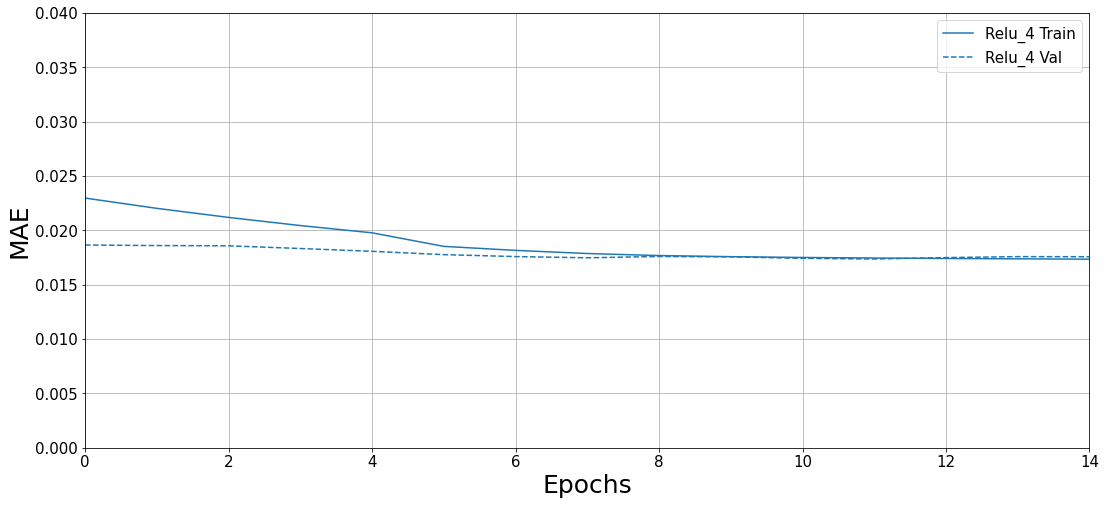

In [47]:
histories['ReLU_4'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.04])
plt.ylabel('MAE')

In [48]:
nsize = 6
activ = "ReLU_Adam"
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0144,  mae:0.0370,  mse:0.0144,  val_loss:0.0037,  val_mae:0.0198,  val_mse:0.0037,  
...........................

Text(0, 0.5, 'MAE')

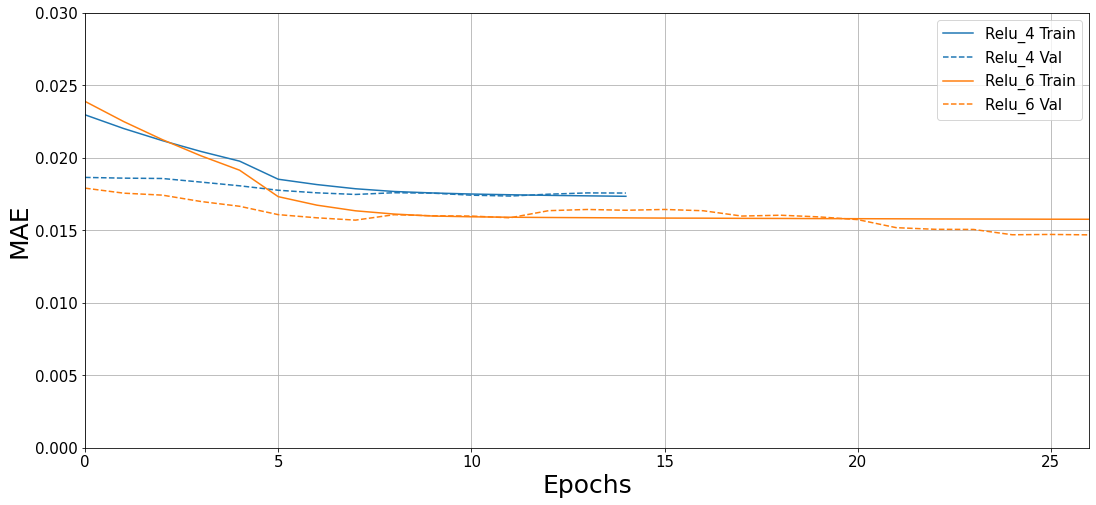

In [49]:
histories['ReLU_6'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.03])
plt.ylabel('MAE')

In [50]:
nsize = 8
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0081,  mae:0.0231,  mse:0.0081,  val_loss:0.0035,  val_mae:0.0152,  val_mse:0.0035,  
..............

Text(0, 0.5, 'MAE')

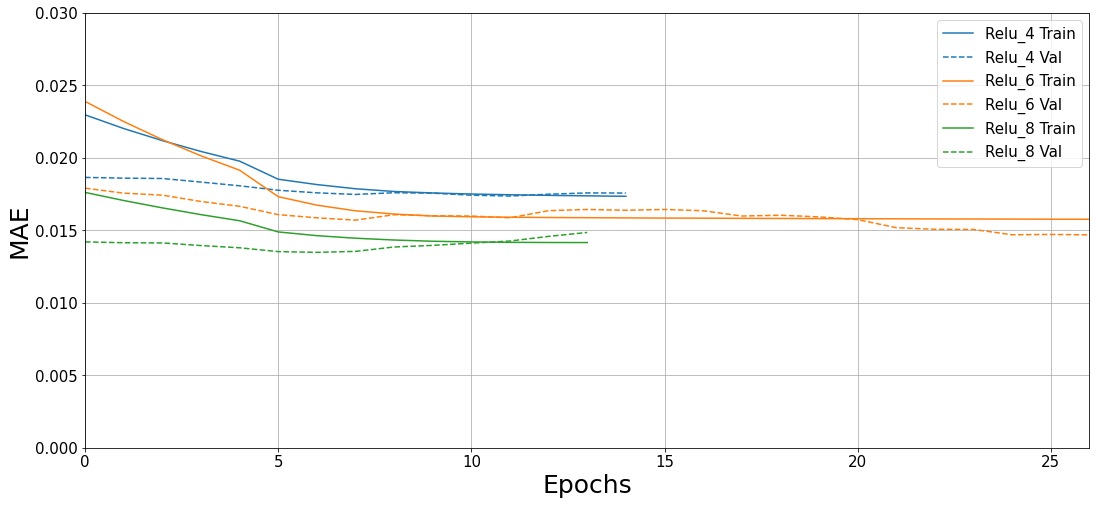

In [51]:
histories['ReLU_8'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.03])
plt.ylabel('MAE')

In [52]:
nsize = 16
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0057,  mae:0.0206,  mse:0.0057,  val_loss:0.0034,  val_mae:0.0136,  val_mse:0.0034,  
.....................

Text(0, 0.5, 'MAE')

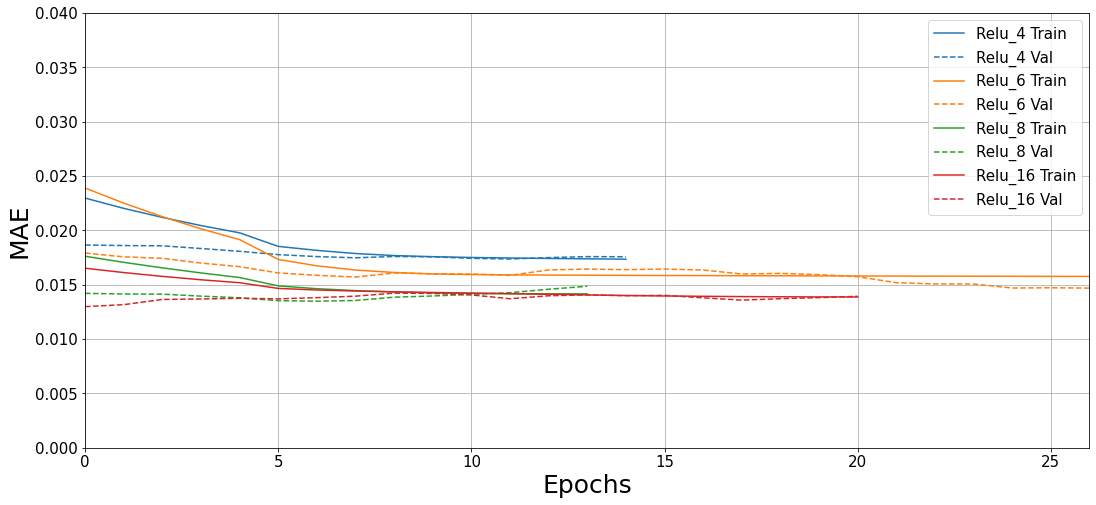

In [54]:
histories['ReLU_16'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.04])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

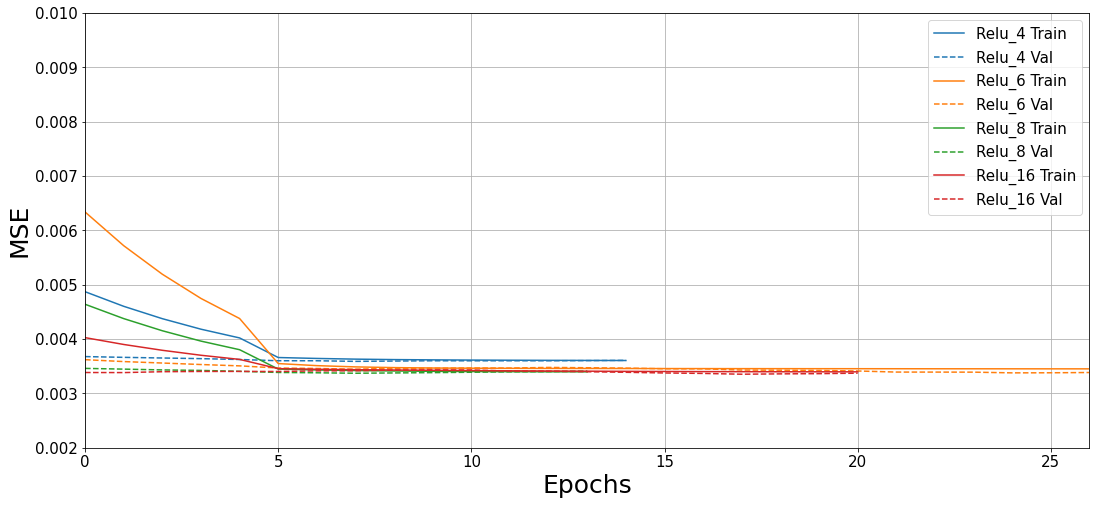

In [56]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.002, 0.01])
plt.ylabel('MSE')

In [57]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:20.5f}".format(mae1))

263676/263676 - 6s - loss: 0.0038 - mae: 0.0171 - mse: 0.0038
Testing set for model 1, Mean Abs Error:              0.01715


In [58]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

263676/263676 - 6s - loss: 0.0036 - mae: 0.0154 - mse: 0.0036
Testing set for model 2, Mean Abs Error:              0.01544


In [59]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

263676/263676 - 6s - loss: 0.0036 - mae: 0.0130 - mse: 0.0036
Testing set for model 3, Mean Abs Error:              0.01301


In [60]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

263676/263676 - 6s - loss: 0.0036 - mae: 0.0125 - mse: 0.0036
Testing set for model 4, Mean Abs Error:              0.01251


In [61]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.017147096, 0.015435261, 0.013005932, 0.012508293]

In [62]:
mse = [ mse2, mse2, mse3, mse4 ]
mse

[0.0036328589, 0.0036328589, 0.0035867144, 0.0035706472]

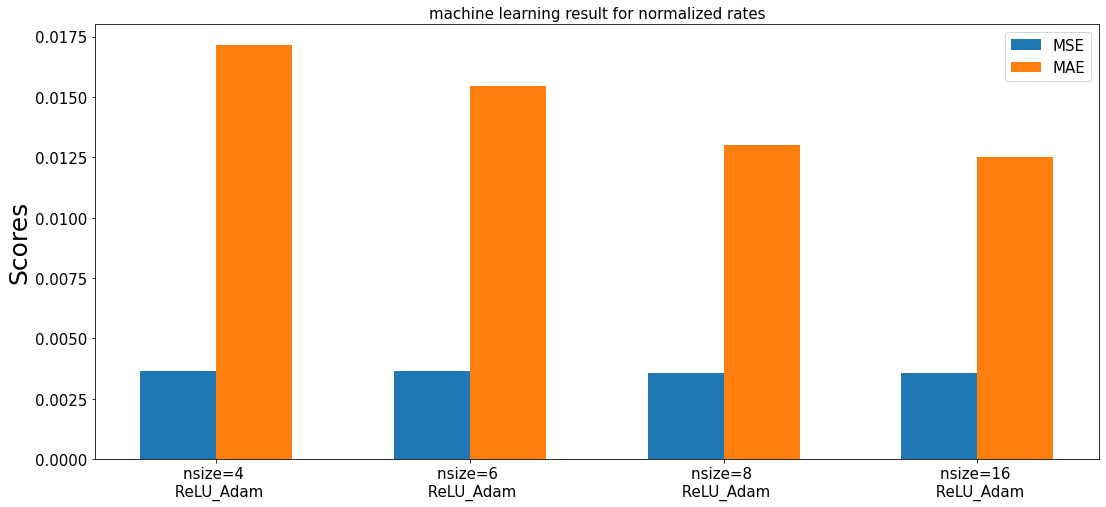

In [63]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'nsize=4 \n ReLU_Adam',
 'nsize=6 \n ReLU_Adam',
 'nsize=8 \n ReLU_Adam',
 'nsize=16 \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [64]:
test_true_mass  = np.exp(test_labels.pop('depo'))

In [65]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [66]:
labels = [ "depo" ]

p1 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

In [67]:
test_predict1 = backtransform(p1,train_labels_stats)

In [68]:
test_predict1_mass  = np.exp(test_predict1['depo'])

In [69]:
p2 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict2 = backtransform(p2,train_labels_stats)

test_predict2_mass  = np.exp(test_predict2['depo'])

In [70]:
p4 = pd.DataFrame(data=model4.predict(normed_test_data2), columns=labels)
test_predict4 = backtransform(p4,train_labels_stats)
test_predict4_mass  = np.exp(test_predict4['depo'])

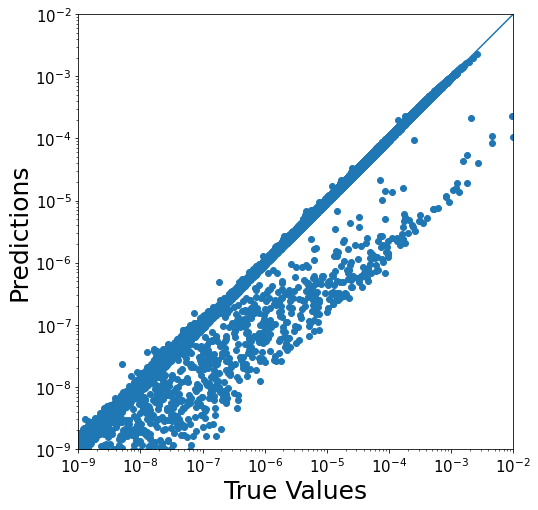

In [72]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-9, 1e-2
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

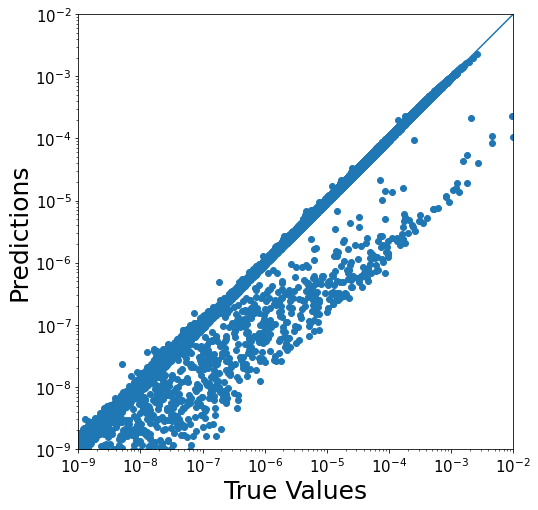

In [74]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

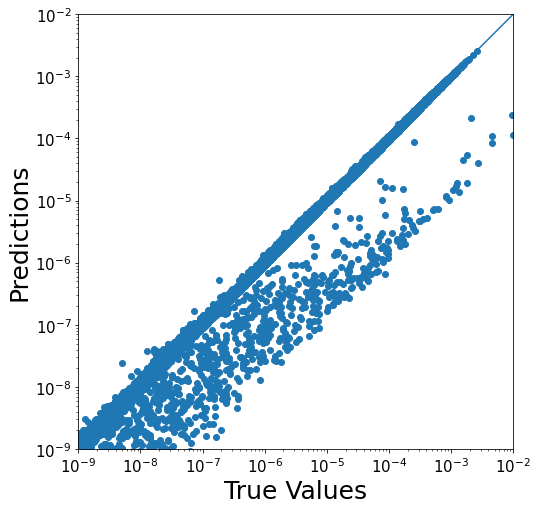

In [75]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict4_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [76]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'13'

In [77]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, labels_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["out_logtransform"] = xr.DataArray(labels_ltf, dims=("Nout_{}".format(nout)))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [78]:
labels   = 'depo_ice_mass'
logtransformOutput = np.array([True], dtype=bool)

features = 'q_ice, n_ice, T, rho'
logtransformInput = np.array([True, True, False, False], dtype=bool)

filename = 'saved_model_v2/depo_ice_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)
filename = 'saved_model_v2/depo_ice_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)
filename = 'saved_model_v2/depo_ice_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)
filename = 'saved_model_v2/depo_ice_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)


Saving model to saved_model_v2/depo_ice_model1_13.nc
  Features:   q_ice, n_ice, T, rho
  Labels:     depo_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 4), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 4), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 1), Activation: linear
Saving model to saved_model_v2/depo_ice_model2_13.nc
  Features:   q_ice, n_ice, T, rho
  Labels:     depo_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 6), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 6), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 1), Activation: linear
Saving model to saved_model_v2/depo_ice_model3_13.nc
  Features:   q_ice, n_ice, T, rho
  Labels:     depo_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 8), Activation: relu
  Layer 1: <class 'tensor